In [61]:
from os import listdir
from os.path import isfile, join
from signal import signal
import numpy
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import seaborn as sns
import pandas as pd
import networkx as nx



In [62]:
mypath='C:/Users/rusan/AppData/Local/Programs/Python/Python311/work/diplom/imagePage'
onlyfiles = [ f for f in listdir(mypath) if isfile(join(mypath,f)) ]
images = numpy.empty(len(onlyfiles), dtype=object)
arr3D = np.empty((1200,512,512), dtype='uint8')
for n in range(0, len(onlyfiles)):
    tmp = cv2.imread(join(mypath,onlyfiles[n]), 0)
    arrTmp = np.asarray(tmp)
    arrTmp = cv2.GaussianBlur(arrTmp, (11, 11),0) #19,19
    images[n] = arrTmp
    arr3D[n] = images[n]

In [63]:
def bildHist2d(i1, i2, j1, j2):
    cellOver = arr3D[:300, i1:i2, j1:j2]
    intens = cellOver.reshape(300*(i2-i1)*(j2-j1),)
    time = []
    for i in range(300):
        for j in range((i2-i1)*(j2-j1)):
            time.append(i)
    xedges = range(300)
    yedges = range(53)
    pdf = PdfPages("2dhist2.pdf")
    #plt.hist2d(time,intens, bins=[xedges,yedges],cmap=plt.cm.jet)
    #plt.xlabel("время")
    #plt.ylabel("интенсивность")
    #plt.colorbar(label = "скопление точек")
    #pdf.savefig()
    #pdf.close()
    #plt.show()
    

In [64]:
def bildGraphOut(corr_matrix, cellOver1):
    cellOver = cellOver1[0,:,:].copy()
    cellOver = cellOver.astype('int32')
    plt.imshow(cellOver)
    plt.show()
    ctolb = cellOver.shape[1] 
    G = nx.Graph()
    column_names = range(len(corr_matrix))
# Add nodes to the graph
    G.add_nodes_from(column_names)
    threshold = 0.92
# Add edges to the graph
    for i, column_1 in enumerate(column_names): 
        coordI = [i // ctolb, i % ctolb]
        for j, column_2 in enumerate(column_names):
            coordJ = [j // ctolb, j % ctolb]
            evclideanDist = np.sqrt((coordI[0] - coordJ[0])**2+ (coordI[1] - coordJ[1])**2)
            if 3 <= 3*evclideanDist and i < j and corr_matrix[i][j] > threshold:
                G.add_edge(column_1, column_2)

# Plot the graph
    #pos = nx.spring_layout(G)
    #nx.draw(G, pos, with_labels=True)
    #plt.show()

    components = nx.connected_components(G)
    arrForGraphOut = []
# Print the connected components
    componentsCopy = components
    x = list(componentsCopy)
    for component in x:
    #print(component)
        tmp = []
        for i in component:
            tmp.append([i // ctolb, i % ctolb])
        arrForGraphOut.append(tmp)
    curr = 0
    for i in arrForGraphOut:
        curr += 1
        for j in i:
            cellOver[j[0], j[1]] = curr 
    #plt.imshow(cellOver, cmap = 'jet')
    #plt.colorbar()
    #plt.show()

    plt.imshow(cellOver[0, :, :])
    plt.title("Изображение клетки")
    plt.colorbar()
    plt.show()






In [65]:
def bildCorrArray(i1,i2,j1,j2):
    cellOver = arr3D[:300, i1:i2, j1:j2]
    res = []
    for i in range(i2-i1):
        for j in range(j2-j1):
            res.append(cellOver[:,i,j])
    res = np.asarray(res)
    corr_matrix=np.corrcoef(res)
    pdf = PdfPages("corr1.pdf")
    plt.imshow(corr_matrix, interpolation='bilinear')
    plt.xlabel("пиксели")
    plt.ylabel("пиксели")
    plt.colorbar()
    pdf.savefig()
    pdf.close()
    plt.show()
    #bildGraphOut(corr_matrix,cellOver)
    plt.imshow(cellOver[0,:,:])
    plt.title("Изображение клетки")
    plt.show()
    return corr_matrix

In [66]:
##бред
def matrixEvclideanDistError(i1,i2,j1,j2):
    corrMatrix = bildCorrArray(i1,i2,j1,j2)
    sizeMatrix = corrMatrix.shape[0]
    res = np.zeros(shape = (sizeMatrix, sizeMatrix))
    outMatrix = np.zeros(shape = (i2-i1, j2-j1))
    needDist = 2
    tmp = []
    flag = False
    flag1 = False
    kLeft = -1
    kRight = -1
    pLeft = -1
    pRight = -1
    ## первые два цикла пробегают по пустому массиву, остальные по корелляционной матрице
    for i in range(sizeMatrix):
        for j in range(sizeMatrix):
            if i == 4 and j == 4:
                print("f")
            if i - needDist > 0:
                kLeft = i - needDist
            else:
                kLeft = i
            if i + needDist >= sizeMatrix - 1:
                kRight = i 
            else:
                kRight = i + needDist 

            if j - needDist > 0:
                pLeft = j - needDist
            else:
                pLeft = j
            if j + needDist >= sizeMatrix - 1:
                pRight = j 
            else:
                pRight = j + needDist 
            for k in range(kLeft, kRight):
                for p in range(pLeft, pRight):
                    evclideanDist = np.sqrt((i - k)**2 + (j - p)**2)
                    if evclideanDist <= needDist and evclideanDist != 0. :
                        tmp.append(corrMatrix[k][p])
                        flag = False
                    else:
                        if flag == True:
                            flag1 = True 
                        flag = True
                        #break
                if flag1 == True:
                    flag1 = False
                    #break
            try:
                res[i][j] = sum(tmp)/len(tmp)
            except:
                print(i, j)
                
            tmp = []
    res = np.asarray(res)
    for i in range(len(res) - 1):
        for j in range(len(res) - 1):
            outMatrix[(i+j)//sizeMatrix][(i+j)%sizeMatrix] = res[i][j]




    

In [67]:
#бред 
def matrixEvclideanDistError2(i1,i2,j1,j2):
    corrMatrix = bildCorrArray(i1,i2,j1,j2)
    middleCorr = []
    for i in corrMatrix:
        middleCorr.append(sum(i)/len(i))
    outMatrix = np.zeros(shape = (i2-i1, j2-j1))
    needDist = 3
    tmp = []
    for i in range(i2 - i1):
        for j in range(j2 - j1):
            if i - needDist > 0:
                kLeft = i - needDist
            else:
                kLeft = 0
            if i + needDist >= i2 - i1:
                kRight = i2 - i1 # -1 
            else:
                kRight = i + needDist 

            if j - needDist > 0:
                pLeft = j - needDist
            else:
                pLeft = 0
            if j + needDist >= j2 - j1:
                pRight = j2 - j1 # -1
            else:
                pRight = j + needDist 
            for k in range(kLeft, kRight):
                for p in range(pLeft, pRight):
                    evclideanDist = np.sqrt((i - k)**2 + (j - p)**2)
                    if evclideanDist <= needDist and evclideanDist != 0:
                        tmp.append(middleCorr[i+j])
            try:
                outMatrix[i][j] = sum(tmp)/len(tmp)
            except:
                print(i, j)
            tmp = []
    plt.imshow(outMatrix)
    
    plt.colorbar()
    plt.show()
                        
    
    

In [68]:
def matrixEvclideanDist(i1,i2,j1,j2):
    corrMatrix = bildCorrArray(i1,i2,j1,j2)
    middleCorr = []
    outMatrix = np.zeros(shape = (i2-i1, j2-j1))
    needDist = 3
    tmp = []
    xx = j2-j1 -1 # нужна, чтобы перейти на другую строку
    for i in range(i2 - i1):
        for j in range(j2 - j1):
            if i - needDist > 0:
                kLeft = i - needDist
            else:
                kLeft = 0
            if i + needDist >= i2 - i1:
                kRight = i2 - i1
            else:
                kRight = i + needDist + 1

            if j - needDist > 0:
                pLeft = j - needDist
            else:
                pLeft = 0
            if j + needDist >= j2 - j1:
                pRight = j2 - j1
            else:
                pRight = j + needDist + 1
            #print(kLeft, "<-", i, "->", kRight)
            #print(pLeft, "|-", j , "-|" , pRight)
            for k in range(kLeft, kRight):
                for p in range(pLeft, pRight):
                    evclideanDist = np.sqrt((i - k)**2 + (j - p)**2)
                    if evclideanDist <= needDist and evclideanDist != 0: #needDist - 0.5 <= evclideanDist <= needDist + 0.5
                        coord1 = i*xx+i+j
                        coord2 = k*xx+k+p
                        tmp.append(corrMatrix[i*xx+i+j][k*xx+k+p])
            try:
                outMatrix[i][j] = sum(tmp)/len(tmp)
            except:
                print(i, j)
            tmp = []
    #print(corrMatrix)
    #print(outMatrix)
    plt.imshow(outMatrix)
    plt.title("Компоненты связности")
    plt.colorbar()
    plt.show()
                        
    
    

In [69]:
def corrPair(i1,i2,j1,j2):
    cellOver = arr3D[:300, i1:i2, j1:j2]
    pixelFromTheTopCell = cellOver[:, 20, 23]
    neighboringPixelForTheTopOne = cellOver[:, 19, 23]
    pixelFromTheBottomCell = cellOver[:,43,4]
    pixelBetweenTheUpperAndLowerCell = cellOver[:,30,15]
    pixelNeutral = cellOver[:,2,40]
    #df = pd.DataFrame({'Name':['pixelFromTheTopCell', 'neighboringPixelForTheTopOne', 'pixelFromTheBottomCell', 'pixelBetweenTheUpperAndLowerCell','pixelNeutral'], 
     #                  'value':[pixelFromTheTopCell, neighboringPixelForTheTopOne, pixelFromTheBottomCell, pixelBetweenTheUpperAndLowerCell, pixelNeutral]})
    time = range(cellOver.shape[0])
    res = [pixelFromTheTopCell, neighboringPixelForTheTopOne, pixelFromTheBottomCell, pixelBetweenTheUpperAndLowerCell, pixelNeutral]
    df = pd.DataFrame({'пиксель в верхней кл': pixelFromTheTopCell,
                      'соседний пиксель в верхней кл' : neighboringPixelForTheTopOne,
                      'пиксель в нижней кл' : pixelFromTheBottomCell,
                      'пиксель между верхней и нижней' : pixelBetweenTheUpperAndLowerCell,
                      'нейтральный пиксель' : pixelNeutral})
    
    sns.pairplot(df, kind="scatter", markers=["o", "s"])
    
    


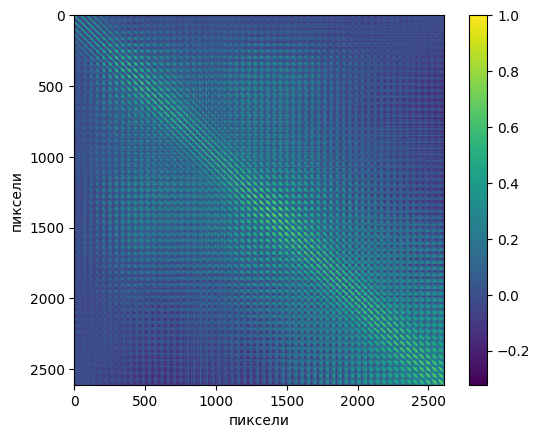

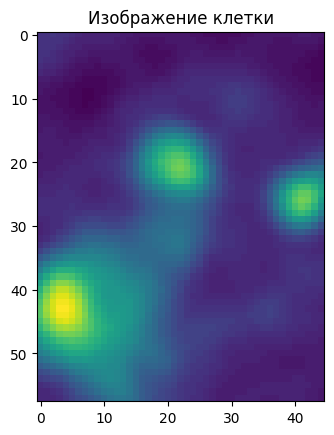

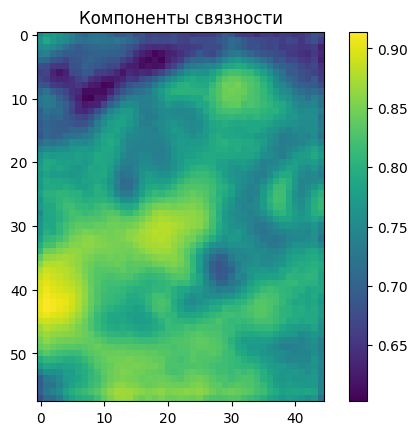

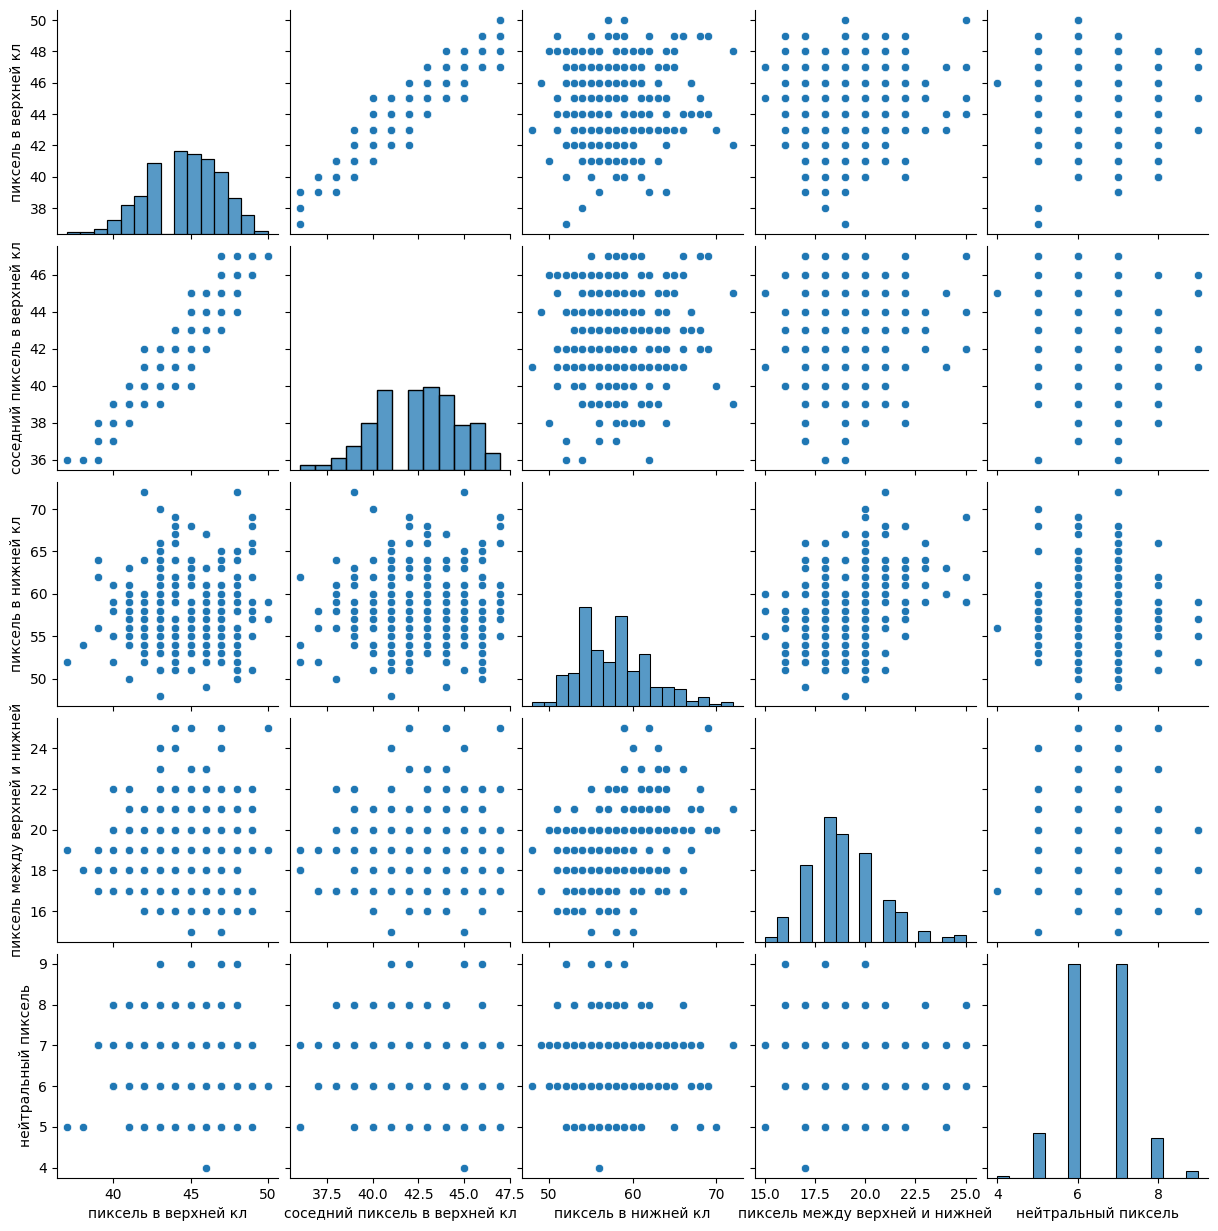

In [70]:
"""bildHist2d(35,53,120,139)
bildCorrArray(35,53,120,139)
bildHist2d(115,133,453,472)
bildCorrArray(115,133,453,472)
bildHist2d(90,115,350,380)
bildCorrArray(90,115,350,380)
bildHist2d(275,295,160,195)
bildCorrArray(275,295,160,195)
bildHist2d(70,113,475,512)
bildCorrArray(70,113,475,512)
bildHist2d(260,280,435,460)
bildCorrArray(260,280,435,460)
bildHist2d(400,418,25,50)"""
#bildCorrArray(400,418,25,50)
#matrixEvclideanDist(90,115,350,380)
#bildHist2d(35:53,120:139)



"""matrixEvclideanDist(35,53,120,139)

matrixEvclideanDist(115,133,453,472)

matrixEvclideanDist(90,115,350,380)

matrixEvclideanDist(275,295,160,195)

matrixEvclideanDist(70,113,475,512)

matrixEvclideanDist(260,280,435,460)"""

matrixEvclideanDist(390,448,15,60)
corrPair(390,448,15,60)
#matrixEvclideanDist(400,418,25,50)

#matrixEvclideanDist(255,300,140,210)
print("11")
